# Nifty 50 Partial Replication 
Index funds have become a household occurence in the financial sphere, especially for retail investors, due to their simplicity, diversification and low cost compared to actively managed funds. Following an index can be done in one of two ways:
- **Full replication:** The most common approach, where a fund holds all constituent stocks present in the index, with the same weights as the index.
- **Partial Replication:** With this approach, only a subset of the index's constituents is selected, which should aim to approximate the overall index performance.

Partial replication can offer a number of benefits over full replication, but mainly:
- Lower transaction costs: Reducing the number of stocks traded minimizes fees such as brokerage fees.
- Reduced Trading fees: By potentially avoiding low-liquidity stocks, we avoid have wider bid-ask spreads, as well as having less market impact.
- Higher flexibility: Funds can add other constraints on top of avoiding low-liquidity stocks, such as those on sectors or specific stocks, giving them better control over their risk management.
Our project's goal is to apply supervised learning techniques to develop a partial replication strategy, minimizing the tracking error of our portfolio.

## Methodology
The project will focus on the NIFTY 100 index, which includes the top 100 companies in the National Stock Exchange of India (NSE) based on market capitalization. 

We will begin by gathering the minute-level data for both the index as well as the constituents data. Combining the data into a single dataframe, and perform some basic cleaning tasks, removing certain columns with a large number of empty values, as well as rows without target value, etc. Our target variable will be the **NIFTY 100 index price**.

Since our goal is to reduce the number of constituents to use only a subset of the total 100 stocks, our models will follow a 2 step approach:
1. Feature Selection: We will first apply different feature selection techniques, (Lasso regression, Correlation matrix, Mutual information) to identify the most relevant stocks for our model.
2. Model Training: Once the most relevant features (stocks) are selected, we will train different supervised learning models on the reduced dataset, these models will predict the weights for each of the relevant stocks.
To ensure the robustness of the test results, while accounting for the nature of the data (ordered time series) we will use a **sliding window approach**, where:
* A fixed-size window (roughly 1-year) is used to train the model.
* The model will be tested on roughly the next 3 months.
* The window will slide forward, repeating until we use all available data.

For a certain model, the overall out-of-sample error will be the average error over all the windows. The error we will aim to minimize is the **tracking error**, for simplicity models will minimize MSE. Finally, we will compare models by plotting the error vs the number of stocks, to visualize how it evolves as we reduce the size of the subset of constituents chosen.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, ParameterGrid
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("always", category=ConvergenceWarning)
import seaborn as sns
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel,mutual_info_regression
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers

## Tracking Error
Tracking error is the metric most commonly used to judge how well a replicating portfolio tracks the benchmark index, for full replication we would expect this to be close to 0 (slightly higher than 0 due to transaction costs or rebalancing delays).

The tracking error is defined as the standard deviation of the differences between the index and replicating portfolio over a specified time period. Central to this metric is the time period that the difference in returns is calculated over, usually this is done daily, weekly or monthly.

$$
\text{Tracking Error} = \sqrt{\frac{\sum_{t=1}^T \left( R_{portfolio}(t) - R_{index}(t) \right)^2}{T}}
$$

Where: 
*  $R_{portfolio}(t)$ is the portfolio return at time $t$,  
*  $R_{index}(t)$ is the index's return at time $t$,  
*  $T$  is the total number of time periods.

We base ourselves on this metric, and add a small adjustment, where from the first return of the portfolio, the trading cost is subtracted, this is a simulated trading cost, which we will simply set to 0.2%.

In the next sections we will see that our data comes in minute intervals, so, to obtain the tracking error for daily returns, we will first aggregate the returns per day, and then utilize the formula above. To aggregate returns we do:

$$
R_{\text{daily}} = \left( \prod_{j=1}^{m} (1 + R_{\text{minute},j}) \right) - 1
$$

Where:

* $R_{\text{daily}}$ is the aggregated daily return
* $R_{\text{minute},j}$ is the minute level return
* m: is the number of minute level returns we have per day

In [2]:
def tracking_error(y_true, y_pred):
    # Step 1: Join y_pred into y_true DataFrame
    y_true = pd.DataFrame(y_true)
    y_true.columns = ['target'] 
    
    # Join target and y_pred based on datetime
    data = y_true.copy()
    data['predicted'] = y_pred

    def accumulated_return(returns):
        return (1+returns).prod() - 1
    
    # Group by date, aggregate returns by cumulative product
    daily_data = data.resample('D').apply(accumulated_return)
    # Calculate the differences between the cumulative returns of target and predicted
    diff = daily_data['target'] - daily_data['predicted']
    # print(len(diff), "ERROR: ", np.std(diff))
    # Calculate the tracking error as the standard deviation of the differences
    return np.std(diff)


# Data
The data for this project will be taken from 2 Kaggle datasets:

* [Nifty 100 Constituents](https://www.kaggle.com/datasets/debashis74017/stock-market-data-nifty-50-stocks-1-min-data): This data set will be used to gather price data for all constituents for the NIFTY 100 index. The dataset contains a file per stock, which contains OHLC (Open, High, Low, Close) as well as Volume data.
* [Nifty 100 Index Data](https://www.kaggle.com/datasets/debashis74017/nifty-50-minute-data): This data set will be used to get the price data for the NIFTY 100 index price.

In order to speed up the execution, an intermediate dataset is created where we keep only closing prices for all stocks, in one single file. This dataset is [Nifty 100 Closing Only Data](https://www.kaggle.com/datasets/danielbrito99/nifty-50-closing-data). The script used to extract this intermediate data, is described in the cell below.

As was mentioned before our target variable will be the **NIFTY 100 Index Price**, by training the model with a reduced number of constituents to predict the index price based on that reduced subset, we will obtain weights for each of them. During the testing phase, we will use these weights to evaluate the model's performance and verify how well the selected subset mimics the index price. 

directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed
Get the list of files that match the pattern
file_list = glob.glob(pattern)

def fetch_data(cols, file_list):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

df = fetch_data('close')
df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [3]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)
nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN value
num_nan_rows = nan_rows.sum()


print(f"Number of rows with NaN values: {num_nan_rows}")

nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

Number of rows with NaN values: 639555


## Data Cleaning
Our data cleaning will be simple, we will focus on remediating the high number of NaN's present in the dataset.
Most importantly, we will focus on sequences of NaN values, which are problematic for our problem, as conventional techniques such as forward fill or interpolation become less effective the longer the period of missing data. Conversely, sparse or isolated NaNs are less of an issue, as they can be effectively substituted using these techniques with minimal loss of information. 


With this in mind, we perform the following steps:

* Remove NIFTY 50 and NIFTY BANK stocks, as they represent indices, not stocks.
* To get rid of periods where a large number of stocks all are missing data, we remove the rows with higher than 25 NaNs.
* Inspecting the longest NaN period for each column, we will get rid of those columns where the value is large:
    * HDFCAMC
    * ICICIPRULI
    * HDFCLIFE
    * GLAND
    * ADANIGREEN
    * DMART
    * ICICIGI
    * BANDHANBNK
    * INDIGO
    * SBILIFE
    * LICI
    * SBICARD
    * LTI
*  At this point the number of NaN rows and consecutive NaNs is much lower, so we can use forward fill to populate them with the last know values.

In [4]:
def longest_nan_period(series):
    max_nan_period = 0
    current_nan_period = 0
    for value in series:
        if pd.isna(value):
            current_nan_period += 1
            max_nan_period = max(max_nan_period, current_nan_period)
        else:
            current_nan_period = 0
    return max_nan_period

In [5]:
df

,HDFCAMC,APOLLOHOSP,BOSCHLTD,INDUSTOWER,BERGEPAINT,MARICO,ICICIPRULI,HDFCLIFE,SBIN,SUNPHARMA,...,SBICARD,DABUR,SAIL,BRITANNIA,ADANIPORTS,ONGC,EICHERMOT,TECHM,JINDALSTEL,HEROMOTOCO
date,,,,,,,,,,,,,,,,,,,,,
2018-08-06 10:47:00+05:30,1803.95,974.30,19187.45,290.0,316.85,357.95,408.50,485.00,306.70,579.65,...,NaN,435.30,79.35,3194.92,400.70,167.75,2711.30,670.45,207.65,3259.00
2018-08-06 10:48:00+05:30,1803.90,973.70,19187.45,290.0,316.50,357.55,408.10,484.95,306.70,579.30,...,NaN,435.15,79.30,3193.02,400.55,167.55,2710.60,670.55,207.80,3260.60
2018-08-06 10:49:00+05:30,1806.00,973.70,19187.45,290.0,316.85,357.20,408.85,485.00,306.75,579.45,...,NaN,435.70,79.30,3192.50,400.30,167.55,2709.80,670.65,207.55,3259.50
2018-08-06 10:50:00+05:30,1806.35,974.00,19174.90,290.0,316.80,357.65,408.90,484.10,306.75,578.10,...,NaN,435.65,79.30,3192.67,399.80,167.50,2708.05,670.90,207.90,3258.50
2018-08-06 10:51:00+05:30,1809.00,975.15,19190.00,290.0,316.80,357.75,408.85,484.20,306.85,578.50,...,NaN,436.00,79.30,3194.02,400.30,167.40,2709.95,671.20,207.80,3258.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25 12:27:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2589.95
2022-10-25 12:28:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2589.30
2022-10-25 12:29:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2590.20


In [6]:
df.drop(columns=['NIFTY 50', 'NIFTY BANK'], inplace=True)

In [7]:
# Removing rows with more than 25 stocks without data
nan_counts = df.isna().sum(axis=1)
df = df[nan_counts <= 25]

In [8]:
# Now we observe per column, the longest period with NaN values
longest_nan_periods = {column: longest_nan_period(df[column]) for column in df.columns}

# Print the longest NaN period for each column
for column, period in longest_nan_periods.items():
    print(f"Longest period of NaN values in column {column}: {period} periods")

Longest period of NaN values in column HDFCAMC: 305198 periods
Longest period of NaN values in column APOLLOHOSP: 1 periods
Longest period of NaN values in column BOSCHLTD: 3 periods
Longest period of NaN values in column INDUSTOWER: 1 periods
Longest period of NaN values in column BERGEPAINT: 1 periods
Longest period of NaN values in column MARICO: 0 periods
Longest period of NaN values in column ICICIPRULI: 144000 periods
Longest period of NaN values in column HDFCLIFE: 242175 periods
Longest period of NaN values in column SBIN: 0 periods
Longest period of NaN values in column SUNPHARMA: 0 periods
Longest period of NaN values in column COALINDIA: 0 periods
Longest period of NaN values in column WIPRO: 1 periods
Longest period of NaN values in column BAJAJ-AUTO: 1 periods
Longest period of NaN values in column GODREJCP: 1 periods
Longest period of NaN values in column UPL: 0 periods
Longest period of NaN values in column SIEMENS: 0 periods
Longest period of NaN values in column BPCL: 

In [9]:
df.drop(columns=['HDFCAMC', 'ICICIPRULI', 'HDFCLIFE', 'GLAND', 'ADANIGREEN', 'LTI', 'SBICARD',
                 'DMART','ICICIGI','BANDHANBNK','INDIGO','SBILIFE','LICI'], inplace=True)

In [10]:
# Get the number of rows with NaN values
nan_rows = df.isna().any(axis=1)
num_nan_rows = nan_rows.sum()
print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 30836


In [11]:
# Drop rows that still have NaNs in place
df.dropna(inplace=True)

In [12]:
df.index = df.index.tz_localize(None)
df_total = df.join(nifty_100_closing, how='left')

In [13]:
df_total.dropna(inplace=True)

In [14]:
# Resample to Hourly Period
hourly_df = df_total.resample('H').last()

In [15]:
# Calculate the percentage change
X_pct_change = df_total.pct_change()

# Define the threshold for large changes (e.g., 100% change)
threshold = 1.0  # 1.0 corresponds to 100% when working with pct_change()

# Find rows with any column having a percentage change greater than the threshold
large_change_rows = X_pct_change[(X_pct_change.abs() > threshold).any(axis=1)]

# Get the number of rows where there are large percentage changes
num_large_changes = large_change_rows.shape[0]

print(f"Number of rows with large changes (>{threshold * 100}%): {num_large_changes}")

Number of rows with large changes (>100.0%): 42


In [16]:
print(len(df_total))

629791


In [17]:
df_total.sort_index(inplace=True)

# Models

Firstly, let's explain the general architecture of the model, firstly, we must understand the pitfalls of using time series data, and how it affects our choice of cross validation strategy. Since the order of data must be preserved, we cannot use a conventional cross validation, and rather opt for a TimeSeriesSplit, specifically, we set the training and test sizes of the window, to get the desired sliding window result, where the training window is roughly 1 year, and the testing widnow around 3 months, this yields a total of 18 windows.

Knowing this, we propose the following general architecture, for a given model and threshold:

For each fold:

1. Perform feature selection (ex: Lasso with high alpha, Dropping Correlated variables, Mutual Information) using the threshold.
2. Train model on reduced feature space, with hyperparameter tuning to choose best parameters.
3. Save the tracking error and number of features (stocks) used in training

Finally, we return the following averages over the folds
* Average number of stocks.
* Average tracking error.

We will observe how different models (LinearRegression, ElasticNet, XGBRegressor and RandomForestRegressor) produce predictions and produce a plot for the average tracking error against the average number of stocks.

## Correlation - Lasso

In [18]:
def remove_correlated_features(X_train, threshold):
    X_train = pd.DataFrame(X_train)
    
    # Compute the correlation matrix (absolute values)
    corr_matrix = X_train.corr().abs()
    
    # Create a mask to select only the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"Features to drop (correlation > {threshold}): {to_drop}")
    selected_features = [i for i in range(X_train.shape[1]) if i not in to_drop]
    
    return selected_features
    

In [19]:
from sklearn.preprocessing import StandardScaler


def Corr_Lasso(threshold, X, y, debug=False):
    tscv = TimeSeriesSplit(n_splits=13, max_train_size=85000, test_size=45000)
    stocks = []
    num_stocks = []
    fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)
        
        # Feature selection using correlation matrix
        selected_indices = remove_correlated_features(X_scaled, threshold)

        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]
        if debug == True:
            print(f"Selected {len(selected_indices)} stocks")
        num_stocks.append(len(selected_indices))
        stocks.append(selected_indices)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_train_selected, y_train_cv)
            y_pred = lasso.predict(X_test_selected)
            fold_score = tracking_error(y_test_cv, y_pred)
            
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alph

        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Threshold: {threshold}, Tracking Error: {average_score}")
    return stocks, average_selected_features, average_score

In [20]:
def Corr_Lasso_plot(X,y):
    thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
    tracking_errors = []
    num_stocks_list = []
    
    for threshold in thresholds:
        print(f"----------Starting threshold: {threshold}-------------")
        _, num_stocks, tracking_err = Corr_Lasso(threshold, X, y, debug=False)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    color = 'tab:blue'    
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Number of Stocks', color=color)    
    ax1.plot(thresholds, num_stocks_list, color=color, marker='o', label='Number of Stocks')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Creating a second y-axis for tracking error
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Tracking Error', color=color)
    #ax2.plot(alphas, tracking_errors, color='tab:green', marker='o', linestyle='--', label='Tracking Error')
    ax2.plot(thresholds, tracking_errors, color=color, marker='x', linestyle='--', label='Adjusted Tracking Error')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Adding a title and legend
    plt.title('Number of Stocks and Tracking Error vs. Alpha')    
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig('Corr-Lasso.png')
    plt.show()

## Lasso - Lasso



We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [21]:
from sklearn.preprocessing import StandardScaler

def Lasso_Lasso(alpha, X, y):    
    tscv = TimeSeriesSplit(n_splits=15, max_train_size=15000, test_size=4500)
    stocks = []
    num_stocks = []
    fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        train_period = X.iloc[train_index].index
        test_period = X.iloc[test_index].index

        # Convert to date format
        train_start_date, train_end_date = train_period.min(), train_period.max()
        test_start_date, test_end_date = test_period.min(), test_period.max()

        print(f"Train period: {train_start_date} to {train_end_date}")
        print(f"Test period: {test_start_date} to {test_end_date}")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)
        
        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=200)
        lasso_fs.fit(X_scaled, y_train_cv)

        # for feature, coef in zip(X_train_cv.columns, lasso_fs.coef_):
        #    print(f"{feature}: {coef}")

        selector = SelectFromModel(lasso_fs, threshold=10e-10, max_features=None)  # Adjust threshold as needed
        X_selected_train = selector.transform(X_scaled)
        X_selected_test = selector.transform(X_test_scaled)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_selected_train, y_train_cv)
            y_pred = lasso.predict(X_selected_test)
            
            fold_score = tracking_error(y_test_cv, y_pred)
            
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alph

        #print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Number of Stocks: {average_selected_features}, Average Tracking Error (bps): {average_score}")
    return stocks, average_selected_features, average_score

In [22]:
def Lasso_Lasso_plot(X,y):
    alphas = np.logspace(-3, -4, 10)
    tracking_errors = []
    num_stocks_list = []
    
    for alpha in alphas:
        print(f"----------Starting alpha {alpha}-------------")
        _, num_stocks, tracking_err = Lasso_Lasso(alpha, X, y)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    color = 'tab:blue'    
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Number of Stocks', color=color)    
    ax1.plot(alphas, num_stocks_list, color=color, marker='o', label='Number of Stocks')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Creating a second y-axis for tracking error
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Tracking Error', color=color)
    #ax2.plot(alphas, tracking_errors, color='tab:green', marker='o', linestyle='--', label='Tracking Error')
    ax2.plot(alphas, tracking_errors, color=color, marker='x', linestyle='--', label='Adjusted Tracking Error')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Adding a title and legend
    plt.title('Number of Stocks and Tracking Error vs. Alpha')    
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig('Lasso-Lasso.png')
    plt.show()

### Mutual Info - Lasso

Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [23]:
from sklearn.preprocessing import StandardScaler


def MI_Experiment(percentile, X, y, model_class, params, debug=False):
    tscv = TimeSeriesSplit(n_splits=15, max_train_size=15000, test_size=4500)
    stocks = []
    num_stocks = []
    fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)        

        selected_features = mi_scores_series[mi_scores_series > threshold_value].index
        selected_indices = [X_train_cv.columns.get_loc(feature) for feature in selected_features]

        # Filter the NumPy arrays based on the selected feature indices
        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]
        # Initial index value
        

        if debug == True:
            print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_params = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for param in ParameterGrid(params):
            if debug == True:
                print(f"Trying combination {param}")
            model = model_class(**param)
            model.fit(X_train_selected, y_train_cv)
            y_pred = model.predict(X_test_selected)

            train_fold_score = tracking_error(y_train_cv, model.predict(X_train_selected))
            fold_score = tracking_error(y_test_cv, y_pred)
            print(f"Train Error: {train_fold_score}, Test Error: {fold_score}")

            if fold_score < best_score:
                best_score = fold_score
                best_params = param
        if debug == True:
            print(f"Best Params for this fold: {best_params}, Best Test Score: {best_score}")
        fold_scores.append(best_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Percentile: {percentile}, Tracking Error: {average_score}")
    return stocks, average_selected_features, average_score

### MI - Lasso

In [24]:
def MI_Lasso_plot(X,y):
    tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.6]
    param_grid = {
        'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
        'max_iter': [15000]
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err = MI_Experiment(percentile, X, y, Lasso, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('Lasso - Tracking Errors vs Number of Stocks')
    plt.grid(True)
    plt.savefig("MI-Lasso.png")
    plt.show()

### MI - ElasticNet

In [25]:
def MI_ElasticNet_plot(X,y):
    tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    param_grid = {
        'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9]
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err = MI_Experiment(percentile, X, y, ElasticNet, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('ElasticNet - Tracking Errors vs Number of Stocks ')
    plt.grid(True)
    plt.savefig("MI-ElasticNet.png")
    plt.show()

TODO: Theil-Sein Linear Regression

### MI-RandomForestRegressor

In [26]:
def MI_RF_plot(X,y):
    tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    param_grid = {
        'n_estimators': [10, 20, 30, 40, 50],       # Number of trees in the forest
        'max_depth': [5, 10, 15],      # Maximum depth of the tree
        'max_samples': [0.5],
        'min_samples_split': [0.05],
        'bootstrap': [True],
        'n_jobs': [-1],
        'max_features': ['sqrt']
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err = MI_Experiment(percentile, X, y, RandomForestRegressor, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('RandomForestRegressor - Tracking Errors vs Number of Stocks ')
    plt.grid(True)
    plt.savefig("MI-RandomForestRegressor.png")
    plt.show()

### MI - XGBoost

In [27]:
def MI_XGBoost_plot(X,y):
    tracking_errors = []
    num_stocks_list = []
    
    percentiles = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    param_grid = {
        'n_estimators': [300, 350, 400],  # Number of boosting rounds
        'learning_rate': [0.075, 0.1, 0.085],  # Step size shrinkage
        'colsample_bytree': [0.5, 0.7],
        'max_depth': [6, 7, 9],  # Maximum depth of a tree
        'n_jobs': [-1],
        'booster': ['gblinear'],
        'tree_method': ['gpu_hist'],
    }
    
    for percentile in percentiles:
        print(f"Starting percentile: {percentile}")
        _, num_stocks, tracking_err = MI_Experiment(percentile, X, y, xgb.XGBRegressor, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks_list, tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('XGBRegressor - Tracking Errors vs Number of Stocks ')
    plt.grid(True)
    plt.savefig("MI-XGBRegressor.png")
    plt.show()

In [28]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = df_total_returns*100
X = df_total_returns.drop(columns=['NIFTY_100'])
y = df_total_returns['NIFTY_100']

hourly_df_total_z = hourly_df.replace(0, np.nan)  # Convert zeroes back to NaNs
hourly_df_total_returns = hourly_df_total_z.pct_change().dropna()
hourly_df_total_returns = hourly_df_total_returns*100
hourly_X = hourly_df_total_returns.drop(columns=['NIFTY_100'])
hourly_y = hourly_df_total_returns['NIFTY_100']

In [29]:
# Corr_Lasso_plot(X,y)

----------Starting alpha 0.001-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 41 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 72 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00
Selected 74 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 77 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 82 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 81 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 78 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 83 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 82 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00
Selected 83 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.961e-01, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.991e-02, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Alpha: 0.001, Number of Stocks: 78.06666666666666, Average Tracking Error (bps): 1.3503236042378859
----------Starting alpha 0.000774263682681127-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 46 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 75 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00
Selected 77 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 79 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.345e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 82 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 83 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 80 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 83 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 82 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.195e-02, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.000774263682681127, Number of Stocks: 79.46666666666667, Average Tracking Error (bps): 1.3475875107297093
----------Starting alpha 0.0005994842503189409-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 47 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 76 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00
Selected 78 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 79 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.776e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 83 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 83 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 82 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 83 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 82 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.546e-02, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.0005994842503189409, Number of Stocks: 80.0, Average Tracking Error (bps): 1.346114748339023
----------Starting alpha 0.00046415888336127773-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 49 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.259e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 78 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00
Selected 79 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 79 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.133e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 83 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 83 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 82 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 84 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 83 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.946e-02, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.00046415888336127773, Number of Stocks: 80.4, Average Tracking Error (bps): 1.3472185248780058
----------Starting alpha 0.00035938136638046257-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 49 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.773e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 78 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00
Selected 79 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 80 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.437e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 84 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 84 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 82 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 85 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 84 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00
Selected 83 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.841e-02, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.00035938136638046257, Number of Stocks: 80.6, Average Tracking Error (bps): 1.346246395117748
----------Starting alpha 0.0002782559402207126-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 52 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.038e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 79 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e-02, tolerance: 2.337e-02
  model = cd_fast.enet_coordinate_descent(


Selected 81 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 82 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.895e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 84 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 84 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 83 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 85 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 84 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.142e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.995e-02, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.0002782559402207126, Number of Stocks: 81.13333333333334, Average Tracking Error (bps): 1.3516995357692354
----------Starting alpha 0.00021544346900318845-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 58 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e-02, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 80 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e-02, tolerance: 2.337e-02
  model = cd_fast.enet_coordinate_descent(


Selected 81 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 83 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.757e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 84 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 84 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 83 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 85 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 84 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.710e-02, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.00021544346900318845, Number of Stocks: 81.66666666666667, Average Tracking Error (bps): 1.3557220206897114
----------Starting alpha 0.0001668100537200059-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 60 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.196e-02, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 81 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e-02, tolerance: 2.337e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 83 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.212e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 84 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 84 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 83 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 85 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 84 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.182e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 82 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e-01, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.0001668100537200059, Number of Stocks: 82.13333333333334, Average Tracking Error (bps): 1.3545237498827485
----------Starting alpha 0.0001291549665014884-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 64 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-02, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 82 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e-02, tolerance: 2.337e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 84 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.645e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 85 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 85 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 83 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 85 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 84 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 84 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e-01, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.0001291549665014884, Number of Stocks: 82.93333333333334, Average Tracking Error (bps): 1.3496517597580975
----------Starting alpha 0.0001-------------
Train period: 2015-02-02 11:00:00 to 2015-02-11 07:00:00
Test period: 2015-02-11 08:00:00 to 2015-08-17 19:00:00
Selected 68 stocks


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e-02, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train period: 2015-02-02 11:00:00 to 2015-08-17 19:00:00
Test period: 2015-08-17 20:00:00 to 2016-02-21 07:00:00
Selected 83 stocks
Train period: 2015-02-02 11:00:00 to 2016-02-21 07:00:00
Test period: 2016-02-21 08:00:00 to 2016-08-26 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.014e-02, tolerance: 2.337e-02
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2015-02-02 11:00:00 to 2016-08-26 19:00:00
Test period: 2016-08-26 20:00:00 to 2017-03-02 07:00:00
Selected 84 stocks
Train period: 2015-06-16 08:00:00 to 2017-03-02 07:00:00
Test period: 2017-03-02 08:00:00 to 2017-09-05 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.090e-02, tolerance: 3.239e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Train period: 2015-12-20 20:00:00 to 2017-09-05 19:00:00
Test period: 2017-09-05 20:00:00 to 2018-03-12 07:00:00
Selected 86 stocks
Train period: 2016-06-25 08:00:00 to 2018-03-12 07:00:00
Test period: 2018-03-12 08:00:00 to 2018-09-15 19:00:00
Selected 86 stocks
Train period: 2016-12-29 20:00:00 to 2018-09-15 19:00:00
Test period: 2018-09-15 20:00:00 to 2019-03-22 07:00:00
Selected 83 stocks
Train period: 2017-07-05 08:00:00 to 2019-03-22 07:00:00
Test period: 2019-03-22 08:00:00 to 2019-09-25 19:00:00
Selected 85 stocks
Train period: 2018-01-08 20:00:00 to 2019-09-25 19:00:00
Test period: 2019-09-25 20:00:00 to 2020-03-31 07:00:00
Selected 84 stocks
Train period: 2018-07-15 08:00:00 to 2020-03-31 07:00:00
Test period: 2020-03-31 08:00:00 to 2020-10-04 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e+00, tolerance: 8.498e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-01-18 20:00:00 to 2020-10-04 19:00:00
Test period: 2020-10-04 20:00:00 to 2021-04-10 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+00, tolerance: 9.858e-02
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2019-07-25 08:00:00 to 2021-04-10 07:00:00
Test period: 2021-04-10 08:00:00 to 2021-10-14 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e+00, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Train period: 2020-01-28 20:00:00 to 2021-10-14 19:00:00
Test period: 2021-10-14 20:00:00 to 2022-04-20 07:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e+00, tolerance: 1.037e-01
  model = cd_fast.enet_coordinate_descent(


Selected 85 stocks
Train period: 2020-08-03 08:00:00 to 2022-04-20 07:00:00
Test period: 2022-04-20 08:00:00 to 2022-10-24 19:00:00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e-01, tolerance: 3.832e-02
  model = cd_fast.enet_coordinate_descent(


Selected 86 stocks
Alpha: 0.0001, Number of Stocks: 83.46666666666667, Average Tracking Error (bps): 1.3437665626777


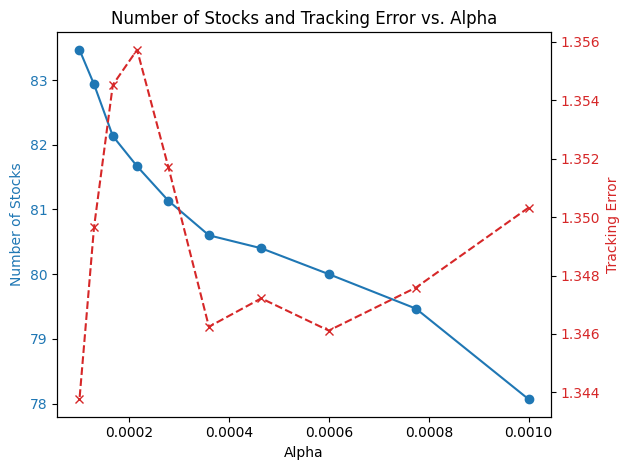

In [30]:
Lasso_Lasso_plot(hourly_X,hourly_y)

In [31]:
#MI_Lasso_plot(X,y)

Starting percentile: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.00033256253066221285, Test Error: 1.4629415840818931
Train Error: 0.001360313401799282, Test Error: 0.5286720548570398


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0011140189554860722, Test Error: 0.40178222062170393
Train Error: 0.0016865974966379894, Test Error: 0.41100534566729324


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.837e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0010334711147001352, Test Error: 0.9521925912708091
Train Error: 0.0024704286607037636, Test Error: 0.4151282084364441
Train Error: 0.0034550525064757846, Test Error: 0.42705834999814846
Train Error: 0.004390063861588344, Test Error: 0.44175058157097635


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.001331281193174784, Test Error: 0.42514980526954277
Train Error: 0.004797773344681374, Test Error: 0.4379646576982237
Train Error: 0.006616116232697359, Test Error: 0.4580049475231932
Train Error: 0.008304466118874865, Test Error: 0.46516080409265775


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.723e-04, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.001797258642096902, Test Error: 0.40105908496996284
Train Error: 0.007007654716458565, Test Error: 0.45468302839829716
Train Error: 0.009303822509455825, Test Error: 0.4711809715907553
Train Error: 0.011311555477373406, Test Error: 0.4923645102754304
Train Error: 0.0021605961473387656, Test Error: 0.40844762560002557
Train Error: 0.008976718058222085, Test Error: 0.46653331821110855
Train Error: 0.011655233367618808, Test Error: 0.4947652275533895
Train Error: 0.014367804196954348, Test Error: 0.5237491087780952
Train Error: 0.004130633596181726, Test Error: 0.4162294809208582
Train Error: 0.01572920600900917, Test Error: 0.5325935750460534
Train Error: 0.021158578317537334, Test Error: 0.5841675786448789
Train Error: 0.025920820542780543, Test Error: 0.6063867885013788
Train Error: 0.005059824810996838, Test Error: 0.41891312536225994
Train Error: 0.019242292699445662, Test Error: 0.5643350574700777
Train Error: 0.025757202187475434, Test Error: 0.6021724808750383
Train

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0003653651432320111, Test Error: 0.8039627508730395
Train Error: 0.0016237809853191561, Test Error: 0.5070831131718748
Train Error: 0.0017556270345344203, Test Error: 0.4527188603894994
Train Error: 0.0021673464216280893, Test Error: 0.456029650460561


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.732e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0009532322022536122, Test Error: 0.8616580134956678
Train Error: 0.0030216909540117824, Test Error: 0.4521319871812885
Train Error: 0.00421331647685697, Test Error: 0.45818498285931736
Train Error: 0.005455287159038699, Test Error: 0.4621115373647015


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0016206898187516824, Test Error: 0.441619246017919
Train Error: 0.006028117476660296, Test Error: 0.4549281484201786
Train Error: 0.008364048770933033, Test Error: 0.4512994386881538
Train Error: 0.010137094479232073, Test Error: 0.4599868213037786
Train Error: 0.0019301368891987743, Test Error: 0.42310549882596465
Train Error: 0.008913477505674268, Test Error: 0.43716637059949986
Train Error: 0.011359551863426328, Test Error: 0.4708844171796801
Train Error: 0.013946820913461588, Test Error: 0.4929303298445456
Train Error: 0.002551773714770114, Test Error: 0.42137132068569094
Train Error: 0.010936960974016774, Test Error: 0.4647610592334258
Train Error: 0.014338321367151394, Test Error: 0.49661889298422307
Train Error: 0.01751130095539281, Test Error: 0.5247898255459543
Train Error: 0.004969643677198006, Test Error: 0.41473253939844285
Train Error: 0.018972929356754275, Test Error: 0.5332307911865221
Train Error: 0.02497146014153128, Test Error: 0.5977343904846811
Train 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.00041346983987696146, Test Error: 0.7977708132198701
Train Error: 0.002739026970199781, Test Error: 0.5616611835818855


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.891e-04, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.443e-04, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0034269027835705478, Test Error: 0.5309935456533883
Train Error: 0.004330702914474214, Test Error: 0.5076169634555295


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0016329100106950059, Test Error: 0.6290898365845551
Train Error: 0.006039347402018365, Test Error: 0.48676249527354576
Train Error: 0.00830232117401214, Test Error: 0.4697627229130241
Train Error: 0.010399142459291836, Test Error: 0.4734539808334442


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.422e-04, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0026930405735532976, Test Error: 0.5545453781353206
Train Error: 0.011293628762342063, Test Error: 0.4797691316461362
Train Error: 0.014307101844346626, Test Error: 0.5085313500226747
Train Error: 0.01737557110829258, Test Error: 0.5194998141531895


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.651e-04, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.003778105652844956, Test Error: 0.5245382173937415
Train Error: 0.015025229667812195, Test Error: 0.5144417161969337
Train Error: 0.019383968573994156, Test Error: 0.5210704891151459
Train Error: 0.02175193244167013, Test Error: 0.5273522530578774
Train Error: 0.005083350923240935, Test Error: 0.5093773275838553
Train Error: 0.018773298512317925, Test Error: 0.5196762606207002
Train Error: 0.02206124800908704, Test Error: 0.5285151954622486
Train Error: 0.024608453507409197, Test Error: 0.5408163555569293
Train Error: 0.009731292480241158, Test Error: 0.5053083572188263
Train Error: 0.02566207891000653, Test Error: 0.5444987095176134
Train Error: 0.029988932885688355, Test Error: 0.557562995303679
Train Error: 0.03237270893494754, Test Error: 0.5636267603302942
Train Error: 0.011623144474296373, Test Error: 0.501413855436113
Train Error: 0.028584197781804, Test Error: 0.552980411309314
Train Error: 0.03212243902441994, Test Error: 0.5623920174507406
Train Error: 0.034752

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0007164869695616471, Test Error: 0.48316881786806226
Train Error: 0.003113259569845735, Test Error: 0.29686721024385176


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.009e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.004255418414344446, Test Error: 0.30563182491861773
Train Error: 0.00496637231539274, Test Error: 0.3132697122334549


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.345e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0016512924134957957, Test Error: 0.3166927092736583
Train Error: 0.006414899036192622, Test Error: 0.3048562058739022
Train Error: 0.008182629943198719, Test Error: 0.2994507688427709
Train Error: 0.010279279820136518, Test Error: 0.29239059605475065


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e-03, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0033608407510913782, Test Error: 0.2998588144219561
Train Error: 0.011521631410190645, Test Error: 0.2888184242792898
Train Error: 0.015821265092666483, Test Error: 0.2854839025810291
Train Error: 0.019319649756633597, Test Error: 0.2626398243840268
Train Error: 0.004952689034748321, Test Error: 0.3066046313297983
Train Error: 0.01676547543754636, Test Error: 0.27954160288546903
Train Error: 0.02152395478455597, Test Error: 0.2511084518556664
Train Error: 0.02476170788167267, Test Error: 0.2440685315196812
Train Error: 0.006145773601186643, Test Error: 0.30640317100389747
Train Error: 0.021028536581459926, Test Error: 0.2533434561238217
Train Error: 0.025074111990440393, Test Error: 0.2440084113548577
Train Error: 0.02697956156315006, Test Error: 0.2476991720141925
Train Error: 0.01031357962686467, Test Error: 0.28629354851039374
Train Error: 0.027635275807527327, Test Error: 0.24853806678996224
Train Error: 0.03042222869739676, Test Error: 0.2534496330293103
Train Error

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.292e-04, tolerance: 6.305e-04
  model = cd_fast.enet_coordinate_descent(


Train Error: 0.0016524470032929877, Test Error: 0.579875389355997
Train Error: 0.005325866782202956, Test Error: 0.521556691028967
Train Error: 0.006846852046393477, Test Error: 0.5299617265217803
Train Error: 0.007853277136874682, Test Error: 0.5337419614437355
Train Error: 0.003914339011311105, Test Error: 0.49995689950310035
Train Error: 0.010171550563868037, Test Error: 0.5354239393568264
Train Error: 0.013550041815943048, Test Error: 0.5441981328990654
Train Error: 0.017018115596567705, Test Error: 0.5480897941179637
Train Error: 0.005932677686176687, Test Error: 0.5090375479991878
Train Error: 0.018964228545889635, Test Error: 0.5491752500140145
Train Error: 0.024037558694460524, Test Error: 0.5522420495652072
Train Error: 0.028427448465510558, Test Error: 0.5481421302984939
Train Error: 0.0081091725561463, Test Error: 0.5204639587708639
Train Error: 0.025302387207582263, Test Error: 0.5506930439441795
Train Error: 0.029035100421358668, Test Error: 0.5501562265891992
Train Error:

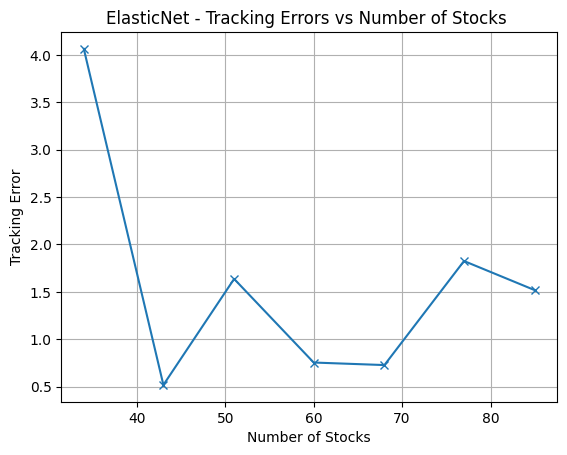

In [32]:
MI_ElasticNet_plot(hourly_X,hourly_y)

In [33]:
#MI_XGBoost_plot(X,y)

# Sparse Autoencoder - Lasso

In [34]:
def autoencoder_feature_selection(X, input_dim, encoding_dim, K):
    # Autoencoder Model
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(input_dim, activation='relu', 
                    activity_regularizer=regularizers.l1(10e-2))(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train autoencoder
    autoencoder.fit(X, X, epochs=50, batch_size=256, validation_split=0.1, verbose=0, shuffle=False)

    # Calculate baseline reconstruction error
    baseline_reconstruction = autoencoder.predict(X, verbose=0)
    baseline_error = np.mean(np.square(X - baseline_reconstruction), axis=0)
    
    # Evaluate contribution of each stock
    importance_scores = []
    
    for i in range(input_dim):
        X_modified = X.copy()
        X_modified[:, i] = 0  # Zero out the i-th feature
        modified_reconstruction = autoencoder.predict(X_modified, verbose=0)
        modified_error = np.mean(np.square(X - modified_reconstruction), axis=0)
        information_loss = np.sum(modified_error - baseline_error)
        importance_scores.append((i, information_loss))
    
    # Rank features based on importance scores
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Select top K features
    top_feature_indices = [index for index, _ in importance_scores[:K]]
    print(f"Selected {len(top_feature_indices)} features")
    
    return top_feature_indices, encoder, autoencoder


In [35]:
def AE_Experiment(K, X, y, model_class, params, debug=False):
    tscv = TimeSeriesSplit(n_splits=15, max_train_size=15000, test_size=4500)
    fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)

        # Create and train Sparse Autoencoder
        input_dim = X_scaled.shape[1]
        features, autoencoder, encoder = autoencoder_feature_selection(X_scaled, input_dim, input_dim, K)

        # Reduce the dataset to use only selected feature indices
        X_train_reduced = X_scaled.copy()
        X_test_reduced = X_test_scaled.copy()
        mask = np.ones(X_train_reduced.shape[1], dtype=bool)
        mask[features] = False
        X_train_reduced[:, mask] = 0
        X_test_reduced[:, mask] = 0
    

        # Encode the data
        X_train_encoded = autoencoder.predict(X_train_reduced, verbose=0)
        X_test_encoded = autoencoder.predict(X_test_reduced, verbose=0)

        best_params = None
        best_score = float('inf')
        for param in ParameterGrid(params):
            if debug:
                print(f"Trying combination {param}")
            model = model_class(**param)
            model.fit(X_train_encoded, y_train_cv)
            y_pred = model.predict(X_test_encoded)

            train_fold_score = tracking_error(y_train_cv, model.predict(X_train_encoded))
            fold_score = tracking_error(y_test_cv, y_pred)
            if debug:
                print(f"Train Error: {train_fold_score}, Test Error: {fold_score}")

            if fold_score < best_score:
                best_score = fold_score
                best_params = param

        if debug:
            print(f"Best Params for this fold: {best_params}, Best Test Score: {best_score}")
        fold_scores.append(best_score)

    average_score = np.mean(fold_scores)

    print(f"Number of stocks: {K}, Tracking Error: {average_score}")
    return average_score

In [36]:
def plot_AE_Lasso(X,y):
    tracking_errors = []
    num_stocks_list = []
    
    num_stocks = [20, 30, 40, 50, 60]
    param_grid = {
        'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
        'max_iter': [15000]
    }
    
    
    for K in num_stocks:
        print(f"Starting portofolio with {K} stocks")
        tracking_err = AE_Experiment(K, X, y, Lasso, param_grid, debug=True)
        tracking_errors.append(tracking_err)

    print(num_stocks_list, tracking_errors)
    
    # Plotting the results
    fig, ax1 = plt.subplots()
    
    # Plotting number of stocks on the primary y-axis
    plt.plot(num_stocks, tracking_errors, marker='x')
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('AE&Lasso - Tracking Errors vs Number of Stocks ')
    plt.grid(True)
    plt.savefig("AE-Lasso.png")
    plt.show()

Starting portofolio with 20 stocks
Selected 20 features
Trying combination {'alpha': 0.0001, 'max_iter': 15000}
Train Error: 0.04946659870648567, Test Error: 0.8497358528228706
Trying combination {'alpha': 0.00025, 'max_iter': 15000}
Train Error: 0.08016583478136073, Test Error: 0.7170650557712424
Trying combination {'alpha': 0.0005, 'max_iter': 15000}
Train Error: 0.07423212879540173, Test Error: 0.6636342960639532
Trying combination {'alpha': 0.00075, 'max_iter': 15000}
Train Error: 0.07605804760080705, Test Error: 0.6473876852022779
Trying combination {'alpha': 0.001, 'max_iter': 15000}
Train Error: 0.07840385854564295, Test Error: 0.6280862959646968
Trying combination {'alpha': 0.002, 'max_iter': 15000}
Train Error: 0.11650393402040514, Test Error: 0.6273285603453372
Trying combination {'alpha': 0.0025, 'max_iter': 15000}
Train Error: 0.12855457991978966, Test Error: 0.6474268801217773
Best Params for this fold: {'alpha': 0.002, 'max_iter': 15000}, Best Test Score: 0.62732856034533

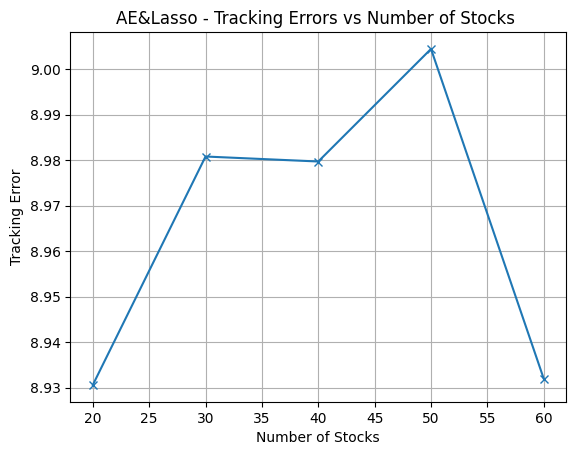

In [37]:
plot_AE_Lasso(hourly_X,hourly_y)

# Conclusions
